In [47]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [49]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        #随机裁剪长度为224的图片
        transforms.RandomHorizontalFlip(),
        #随机水平翻转，默认概率p=0.5
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #这些数随手写的？？
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #从中心进行裁剪
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
##.class()是哪来的，难道是文件夹名字？？

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#使用GPU if available

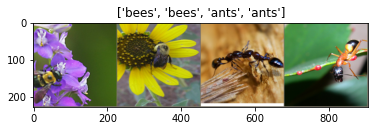

In [50]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
#Dataloader大概会返回一个图片和一个文件夹名，作为一个pair

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [51]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #大括号里面是输出的变量
        print('-' * 10)

        # Each epoch has a training and validation phase
        #每个epoch都要重新训练一次
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                #这里的model就是输入的model啊，就是model_ft
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                #转到GPU训练

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #with后面的括号相当于是否求导的判断条件，但是不是是否进入‘循环’的判断条件
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #if才是是否进入循环的判断条件，如果是val，则不反向传播和更新梯度
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #可能是resnet18对输入求均值，乘以输入图片的数目，得到真实的loss
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                #传入的schedler，更新learning_rate的函数

            epoch_loss = running_loss / dataset_sizes[phase]
            #这个指标有什么具体意义吗
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            #dataset_sizes是一个字典，返回len(...)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                #更新记录
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [52]:
def visualize_model(model, num_images=6):
    was_training = model.training
    #model.training参数查不到啊？？？
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                #num_images=6，传入参数
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    #这个model.training到底是个什么鬼东西
                    #大概每次往model中传入inputs的时候，如果model！=model.trainging会开始训练，模型参数变化
                    return
        model.train(mode=was_training)

In [53]:
model_ft = models.resnet18(pretrained=True)
#导入一个训练过的model
num_ftrs = model_ft.fc.in_features
#提取fc层中固定的参数
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
#修改类别为9，初始的类别为6
 
model_ft = model_ft.to(device)
#整个模型迁移到GPU训练

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#每训练7个epoch学习率乘以0.1

In [54]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5548 Acc: 0.7090
val Loss: 0.1885 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.6649 Acc: 0.7746
val Loss: 0.4492 Acc: 0.8105

Epoch 2/24
----------
train Loss: 0.7183 Acc: 0.7705
val Loss: 0.3688 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.6133 Acc: 0.7582
val Loss: 0.2629 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4182 Acc: 0.8320
val Loss: 0.3565 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.5455 Acc: 0.8156
val Loss: 0.3330 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.3730 Acc: 0.8443
val Loss: 0.2366 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4470 Acc: 0.8443
val Loss: 0.2508 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3294 Acc: 0.8934
val Loss: 0.2850 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2701 Acc: 0.8934
val Loss: 0.2648 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3727 Acc: 0.8402
val Loss: 0.2882 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.1924 Acc: 0.9262
val Loss: 0.2458 Acc: 0.9346

Ep

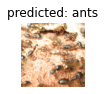

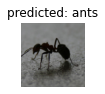

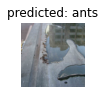

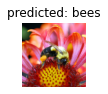

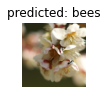

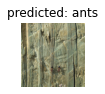

In [55]:
visualize_model(model_ft)

In [60]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
#num_ftrs的值为512，是全连接的输入层维度
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [61]:
#这一部分才是真正的迁移学习部分，fc层之前的参数全部freeze，只训练fc层
#但是训练时间为毛没减少，少了1分半钟
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5941 Acc: 0.6762
val Loss: 0.2233 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.5586 Acc: 0.7336
val Loss: 0.1897 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.7388 Acc: 0.7049
val Loss: 0.1483 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.3625 Acc: 0.8566
val Loss: 0.1579 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.4014 Acc: 0.8074
val Loss: 0.1928 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.5996 Acc: 0.7705
val Loss: 0.1847 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4318 Acc: 0.8279
val Loss: 0.1881 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3902 Acc: 0.8238
val Loss: 0.1857 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.3770 Acc: 0.8525
val Loss: 0.2200 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.4102 Acc: 0.8320
val Loss: 0.1722 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3080 Acc: 0.8730
val Loss: 0.1649 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3769 Acc: 0.8238
val Loss: 0.1822 Acc: 0.9542

Ep